In [18]:
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

# MP Resume Generator

In [2]:
ticks = pd.read_csv('ticks.csv')
ticks.columns = [col.lower().replace(' ', '_') for col in ticks.columns]
ticks['date'] = pd.to_datetime(ticks['date'])
ticks.head(3)

,date,route,rating,notes,url,pitches,location,avg_stars,your_stars,style,lead_style,route_type,your_rating,length,rating_code
0,2025-06-22,"La Cosita, Left",5.7,NaN,https://www.mountainproject.com/route/10587777...,1,California > Yosemite National Park > Yosemite...,2.8,-1,TR,NaN,Trad,NaN,NaN,1800
1,2025-06-22,Sacherer Cracker,5.10a,Tr solo,https://www.mountainproject.com/route/10594553...,1,California > Yosemite National Park > Yosemite...,3.8,-1,TR,NaN,Trad,NaN,150.0,2600
2,2025-06-21,The Nutcracker Suite (aka Nutcracker),5.8,NaN,https://www.mountainproject.com/route/10583350...,4,California > Yosemite National Park > Yosemite...,3.6,-1,Lead,Onsight,Trad,NaN,500.0,2100


Desired features:

1. Summary (# of routes, # of crags, time climbing)
2. Hardest Boulders
3. Hardest leads (sport/trad)
4. Longest Climbs
5. Analytics

In [3]:
# Summary (# routes, how long climbing [first MP tick], # crags)

n_routes = len(ticks)
print(f"Number of Routes Climbed: {n_routes}")

first_tick = ticks['date'].sort_values(ascending=True).dt.date.head(1).values[0]
print(f"First tick: {first_tick}")

climbing_exp = relativedelta(dt.datetime.now().date(),first_tick)
print(f"Climbing for {climbing_exp.years} years, {climbing_exp.months} months")

total_feet_climbed = ticks['length'].sum()
print(f"{round(total_feet_climbed)} feet climbed")
print(f"(that's {round(total_feet_climbed/5280, 1)} miles!)")

Number of Routes Climbed: 700
First tick: 2016-01-09
Climbing for 9 years, 6 months
56065 feet climbed
(that's 10.6 miles!)


In [4]:
# examine location
ticks['loc_trunc'] = ticks['location'].str.split(' > ').str[:5]

# handle international
ticks.loc[ticks['location'].str.startswith('International'), 'loc_trunc'] = ticks['loc_trunc'].str[2:]

# non-internatioal
ticks.loc[~ticks['location'].str.startswith('International'), 'loc_trunc'] = ticks['loc_trunc'].str[:3]

# turn to str
ticks['loc_trunc'] = ticks['loc_trunc'].str.join(' > ')

n_crags = len(ticks['loc_trunc'].unique())
top_5_locs = ticks['loc_trunc'].value_counts()[:5]

print(f"Number of crags visited: {n_crags}")
print("Top 5 Crags:")
top_5_locs


Number of crags visited: 96
Top 5 Crags:


Oregon > Central Oregon > Smith Rock                                       120
New Zealand > South Island > Nelson-Tasman                                  46
Nevada > Southern Nevada > Red Rocks                                        36
Nevada > Southern Nevada > Red Rock Boulders                                25
Thailand > South - Islands & Beaches > Laem Phra Nang (Railay & Tonsai)     23
Name: loc_trunc, dtype: int64

In [5]:
# hardest boulders
boulders = ticks.loc[ticks['style'].isin(['Flash', 'Send'])].sort_values('rating_code', ascending=False)
hardest_boulders = boulders[:5]
hardest_boulders['route'].to_list()

['Rings of Uranus', 'Speech Therapy', 'BiCeption', 'The Pork Chop', 'The Wave']

In [6]:
# hardest leads (sport)
sport_routes = ticks.loc[ticks['route_type'] == 'Sport']
hardest_sp_leads = sport_routes.loc[ticks['lead_style'].isin(['Onsight', 'Flash', 'Redpoint'])].sort_values('rating_code', ascending=False)[:5]
hardest_sp_leads['route'].to_list()

['Lone Pilgrim',
 'L-4 One of the Best',
 'Sweet Pain',
 'As Wicked As It Seems',
 'Feral Pakeha']

In [7]:
# hardest leads (trad)
trad_routes = ticks.loc[ticks['route_type'] == 'Trad']
hardest_tr_leads = trad_routes.loc[ticks['lead_style'].isin(['Onsight', 'Flash', 'Redpoint'])].sort_values('rating_code', ascending=False)[:5]
hardest_tr_leads['route'].to_list()

['Perfect Pitch', 'Profundity', 'Everything Hertz', 'Zion', 'Gang of Foreplay']

In [8]:
# longest routes
longest_routes = ticks.sort_values('length', ascending=False)[:5]
longest_routes['route'].to_list()

['Epinephrine',
 'Solar Slab',
 'Tunnel Vision',
 'Frontside 180',
 'The Spirit of Squamish']

In [9]:
sends = pd.concat([boulders, trad_routes, sport_routes]).sort_values('date').reset_index(drop=True)
rope_sends = pd.concat([trad_routes, sport_routes]).sort_values('date').reset_index(drop=True)


<AxesSubplot:>

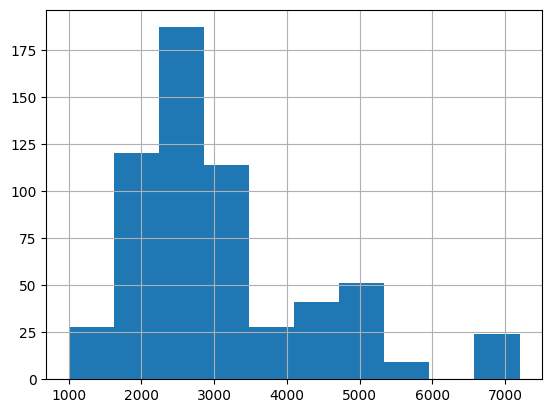

In [10]:
rope_sends['rating_code'].hist()

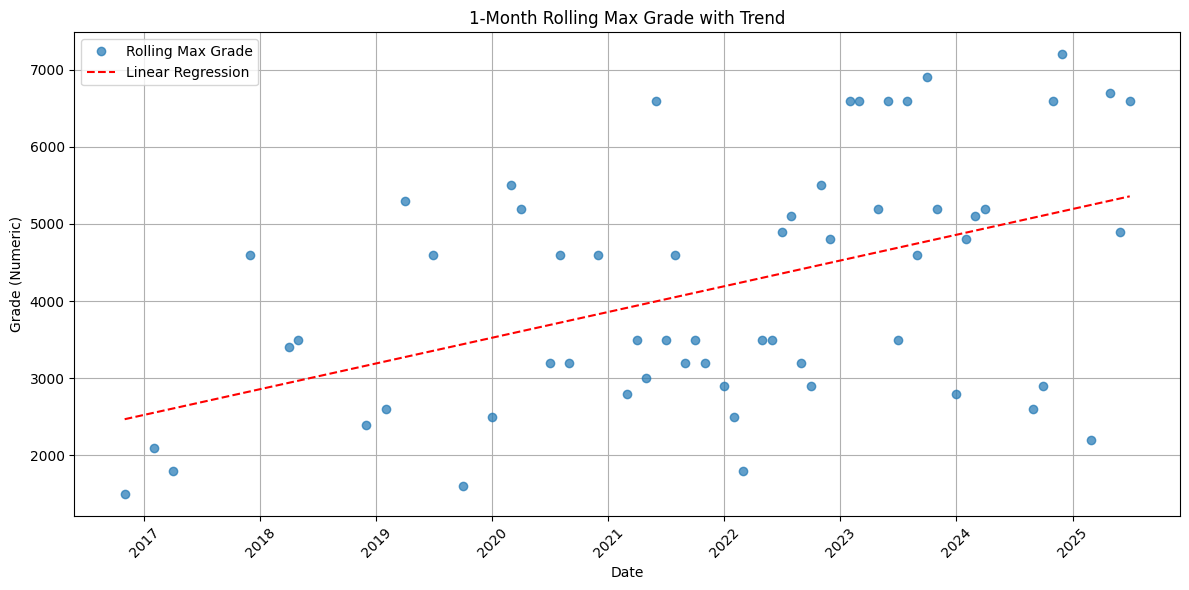

In [23]:
# --- Resample & Rolling Max ---
monthly_max = rope_sends.set_index('date')['rating_code'].resample('M').max()
rolling_max = monthly_max.rolling(window=1, min_periods=1).max()  # smooth trend

# Drop NaNs for regression
rolling_max = rolling_max.dropna()

# --- Prepare for regression ---
X = rolling_max.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = rolling_max.values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(rolling_max.index, rolling_max.values, marker='o', linestyle='', alpha=0.7, label='Rolling Max Grade')
plt.plot(rolling_max.index, y_pred, color='red', linestyle='--', label='Linear Regression')
plt.title("1-Month Rolling Max Grade with Trend")
plt.xlabel("Date")
plt.ylabel("Grade (Numeric)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()